In [1]:
import pytesseract
from PIL import ImageOps
import pyautogui
import time
import re
import pandas as pd
import numpy as np
import datetime as dt
import math

# Configurar o caminho do executável do Tesseract, se necessário
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Ajuste conforme o seu caminho



In [567]:
pyautogui.mouseInfo()

In [ ]:
17,969
657,967

In [482]:
def update_info(x,y):
    pyautogui.moveTo(x, y)
    time.sleep(0.05)
    pyautogui.mouseDown()

In [483]:
def get_info(region):
    image = pyautogui.screenshot(region=region)
    text = pytesseract.image_to_string(image)
    return text


In [628]:
id_torneio = input("Inserir o Id do Torneio")

x_init,x_end = 17,653
y_constant = 400
time_pattern = re.compile(r'\b\d{1,2}:\d{2}:\d{2}\b')


interval_lenght = x_end - x_init

time_u, time_v = np.array([5,192]), np.array([99,209])
time_region = (*time_u,*(time_v-time_u))

remaning_u, remaning_v = np.array([160,191]), np.array([394,212])
remaning_region = (*remaning_u,*(remaning_v-remaning_u))

entries_u, entries_v = np.array([760,121]), np.array([823,149])
entries_region = (*entries_u,*(entries_v-entries_u))
number_of_entries_str = re.findall(r'\b\d+\b', get_info(entries_region))
number_of_entries = int(number_of_entries_str[0])

update_info(x_init,y_constant)
text_time_init = get_info(time_region)
update_info(x_end,y_constant)
text_time_end = get_info(time_region)
start_time, end_time = time_pattern.findall(text_time_init)[0],time_pattern.findall(text_time_end)[0]
time_obj_init, time_obj_end = dt.datetime.strptime(start_time, "%H:%M:%S"), dt.datetime.strptime(end_time, "%H:%M:%S")

delta_x = interval_lenght/((time_obj_end - time_obj_init).seconds/60)
number_of_interaction = math.ceil(interval_lenght/delta_x)


tm_minute_data = []
for i in range(number_of_interaction + 1):
    update_info(x_init,y_constant)
    text_time_interactions = get_info(time_region)
    actually_time = time_pattern.findall(text_time_interactions)[0]
    remaining_number_str = re.findall(r'\b\d+\b', get_info(remaning_region))
    remaining_number = int(remaining_number_str[0])
    minute_data = {
        "index":i,
        "id_torneio":id_torneio,
        "time":actually_time,
        "remaining_players":remaining_number,
        "number_of_entries":number_of_entries

    }
    tm_minute_data.append(minute_data)
    x_init += delta_x

tm_df = pd.DataFrame(tm_minute_data)
tm_df = tm_df.set_index("index")
tm_df.to_csv(f'./data_1_dol_45/{id_torneio}.csv',sep=';')


In [21]:
import os
import matplotlib.pyplot as plt

In [22]:
my_tournments = os.listdir(path="data_1_dol_45")

In [23]:
dflsft = []
for f in my_tournments:
    df = pd.read_csv(os.path.join("data_1_dol_45",f),sep=';')
    dflsft.append(df)

In [24]:
X = pd.concat(dflsft)

In [25]:
X_ = pd.pivot_table(X,index='index',columns="id_torneio",values="remaining_players",aggfunc='first')

Text(0, 0.5, 'Número de Jogadores')

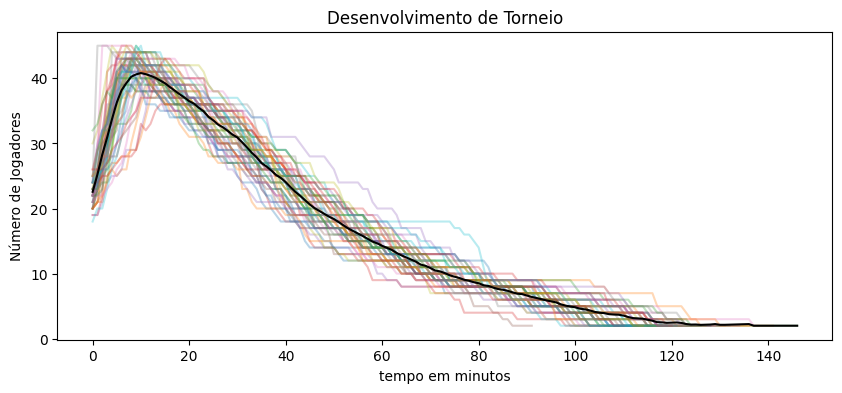

In [26]:
X_.plot(legend=False,alpha=0.3,figsize = (10,4))
X_.mean(axis=1).plot(color='black')
plt.title("Desenvolvimento de Torneio")
plt.xlabel("tempo em minutos")
plt.ylabel("Número de Jogadores")


In [27]:
corte_minuto = X.set_index(["id_torneio",'time']).sort_index()

### Survival Function tempo de sovbrevivencia até ter menos de 7 players no jogo

In [28]:
exemplo = corte_minuto.loc[3796250361].copy()

In [29]:
# tempo necessario ate menor que 8 jogadores
exemplo[exemplo['remaining_players'] < 8].index.min()

'1:13:20'

In [30]:
survival_function_emp = corte_minuto[corte_minuto['remaining_players'] < 8].groupby(level=0)['index'].min()
survival_function_emp.describe()

count     55.000000
mean      86.836364
std        7.918014
min       70.000000
25%       83.000000
50%       87.000000
75%       91.500000
max      107.000000
Name: index, dtype: float64

In [222]:
def CreateSurvivalFunction(n):
    survival_function_emp = corte_minuto[corte_minuto['remaining_players'] < n].groupby(level=0)['index'].min()
    kaplan_table = []
    for i in range(int(survival_function_emp.min()),int(survival_function_emp.max())):
        n_risk = (survival_function_emp >= i).sum()
        d_fail = (survival_function_emp == i).sum()
        kaplan_dict = {
            "time_t":i,
            "n_risk":n_risk,
            "d_fail":d_fail,

        }
        kaplan_table.append(kaplan_dict)
    kaplan_df = pd.DataFrame(kaplan_table).set_index('time_t')
    kaplan_df['fail_prob'] = kaplan_df['d_fail']/kaplan_df['n_risk']
    kaplan_df['conditional_fail_prob'] = 1 - kaplan_df['fail_prob']
    kaplan_df['survival_function'] = kaplan_df.conditional_fail_prob.cumprod()
    return kaplan_df['survival_function']

def fill_prob(s_t):
    espelho = s_t.copy()
    fill_0, fill_1 = espelho.dropna().index.min(),espelho.dropna().index.max()
    s_t.loc[s_t.index < fill_0] = 1
    s_t.loc[s_t.index > fill_1] = 0
    return s_t

In [52]:
survival_lst = []
for i in range(3,8+1):
    conditional_survival_function = CreateSurvivalFunction(i)
    conditional_survival_function.name = f'survival_function_{i-1}_players'
    survival_lst.append(conditional_survival_function)

In [224]:
X = pd.DataFrame(survival_lst).T.sort_index()
X = X.apply(lambda row: fill_prob(row),axis=1)
payoff = dict(zip(X.columns, [9.16,6.6,4.76,3.44,2.48,1.79]))
payoff = pd.Series(payoff)

### Função de sobrevivencia para quantidade de jogadores

<Axes: xlabel='time_t'>

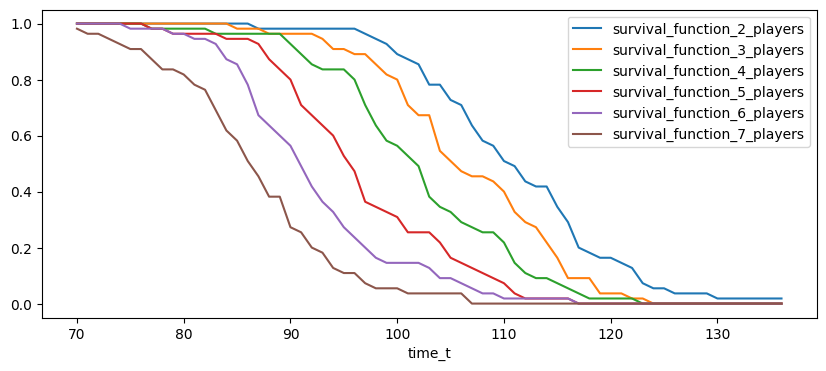

In [300]:
X.plot(figsize=(10,4))

In [283]:
marginal_payoff = payoff.sort_values().diff().fillna(1.79)

In [312]:
t = 85
(marginal_payoff.sort_values() * (1 - X.loc[t])).sum() 

0.9827272727272731